In [1]:
## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [3]:
## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

# Read data

In [4]:
## Reading relevant data
match_lvl_data = pd.read_csv('amex_data/match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('Features using cheatsheet/StrikeRate/batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('amex_data/bowler_level_scorecard.csv')
train_data = pd.read_csv('amex_data/train_data_with_samplefeatures.csv')
test_data = pd.read_csv('amex_data/test_data_with_samplefeatures.csv')

# Printing shape and sample rows of each dataset

In [5]:
match_lvl_data.shape
match_lvl_data.head(2)

(1689, 30)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0


In [6]:
batsman_lvl_data.shape
batsman_lvl_data.head(2)

(24483, 24)

,match id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt,count,running_sum,avg_sr_running
0,8638034,DG Be,31464,NZ:Right-hand bat:Right-arm medium:,0,0,1,8,11,5.1,caught,JS Nm,HK Bt,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,72.73,1.0,NaN,01-01-2021,1,72.73,72.730
1,8638041,DG Be,31464,NZ:Right-hand bat:Right-arm medium:,0,0,1,2,4,9.6,caught,MB Bn,MJ Mn,4195827.0,NZ:Right-hand bat:Right-arm medium:,0.0,0.0,50.00,NaN,NaN,02-01-2021,2,122.73,61.365


In [7]:
bowler_lvl_data.shape
bowler_lvl_data.head(2)

(18539, 18)

,match id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.5,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.5,0,7.0,3,1,2,0,2021-01-01


In [8]:
train_data.shape
train_data.head(2)

(948, 25)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_30runs_last15,avg_sr_ratio
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,20-10-2022,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,0.777778,0.826481
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,23-01-2022,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1.000000,1.158036


In [9]:
test_data.shape
test_data.head(2)

(271, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_30runs_last15,avg_sr_ratio
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,11-07-2022,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,0.000000,0.810099
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,21-09-2022,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5,0.774194,1.187778


In [10]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

# Code to plot RnP

In [11]:
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\1940123182.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Helper function

In [12]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

# Feature creation

## 1. team_count_50runs_last15

In [13]:
# Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games

def no50sLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.

In [14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

100%|██████████| 948/948 [00:15<00:00, 61.63it/s]


In [15]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns

### Visualizing

In [16]:
train_data.shape
train_data.tail(2)

(948, 26)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_30runs_last15,avg_sr_ratio,winner_01
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,07-05-2023,night match,In Pr Le,2023,4661,1.0,1.487805,182.800000,66.67,133.375000,0.725,0.994297,1
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,20-06-2023,day/night match,Vy Bt,2023,1245,3.0,1.975610,167.333333,100.00,164.192308,2.700,1.151987,1


slope: 0.59 / 0.38 =  1.54


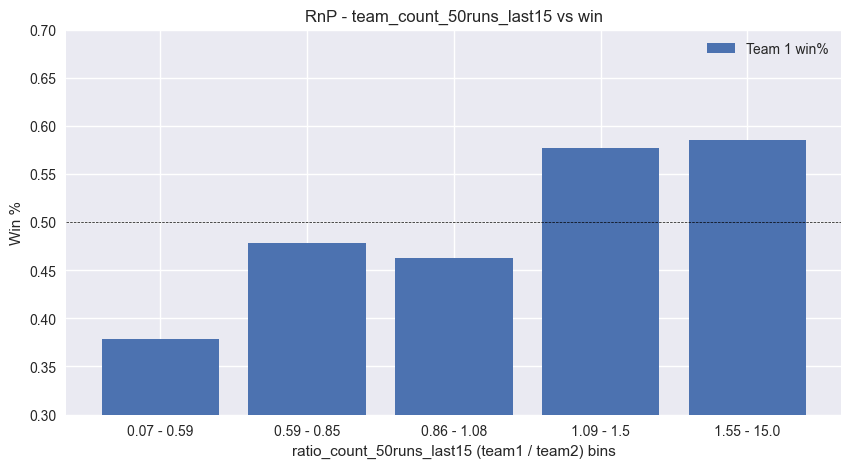

In [17]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_50runs_last15')

In [18]:
## Doing similar process for test dataset

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_50runs_last15'] = (test_data['team1_count_50runs_last15'])/(test_data['team2_count_50runs_last15']+1)
test_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 271/271 [00:04<00:00, 61.24it/s]


(271, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_30runs_last15,avg_sr_ratio
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,11-07-2022,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000,0.019608,NaN,0.00,NaN,0.000000,0.810099
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,21-09-2022,night match,Cn Pr Le,2022,13915,1.125,0.344262,151.285714,66.67,153.5,0.774194,1.187778


## SR Feature

In [19]:
# Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games

def Avg_SR_last_n(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        # df_rel['SR'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nanmean(df_rel['strike_rate']))# Avg up SR for the player and append to a list. We will do this for all players.
    return np.nanmean(res_list)# Avg up values of the list which is avg SR of batsmen in team

In [20]:
# Computing avg SR in last 5 games for team1 for train dataset.
train_data['avg_sr_t1'] = train_data.progress_apply(lambda x: \
            Avg_SR_last_n(player_list=x['team1_roster_ids'], date=x['match_dt'], n=5), axis=1)
# Computing avg SR in last 5 games for team2 for train dataset.
train_data['avg_sr_t2'] = train_data.progress_apply(lambda x: \
            Avg_SR_last_n(player_list=x['team2_roster_ids'], date=x['match_dt'], n=5), axis=1)

  0%|          | 0/948 [00:00<?, ?it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:22: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))# Avg up SR for the player and append to a list. We will do this for all players.
  2%|▏         | 16/948 [00:00<00:13, 71.03it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(res_list)# Avg up values of the list which is avg SR of batsmen in team
  0%|          | 0/948 [00:00<?, ?it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:22: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))# Avg up SR for the player and append to a list. We will do this for all players.
  6%|▌         | 57/948 [00:00<00:12, 70.62it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(res_list)# Avg up values of th

In [21]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['avg_sr_ratio'] = (train_data['avg_sr_t1']+1)/(train_data['avg_sr_t2']+1)
train_data.drop(columns=['avg_sr_t1','avg_sr_t2'], inplace=True) # dropping intermediate columns

In [22]:
train_data.shape
train_data.tail(2)

(948, 26)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_30runs_last15,avg_sr_ratio,winner_01
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,07-05-2023,night match,In Pr Le,2023,4661,1.0,1.487805,182.800000,66.67,133.375000,0.725,0.994297,1
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,20-06-2023,day/night match,Vy Bt,2023,1245,3.0,1.975610,167.333333,100.00,164.192308,2.700,1.151987,1


slope: 0.55 / 0.45 =  1.21


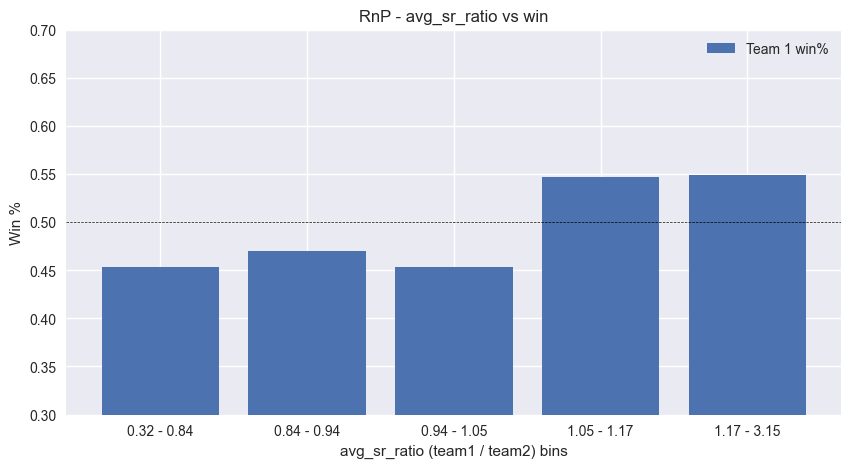

In [23]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'avg_sr_ratio')

In [24]:
## Doing similar process for test dataset

test_data['avg_sr_t1'] = test_data.progress_apply(lambda x: \
            Avg_SR_last_n(player_list=x['team1_roster_ids'], date=x['match_dt'], n=5), axis=1)
test_data['avg_sr_t2'] = test_data.progress_apply(lambda x: \
            Avg_SR_last_n(player_list=x['team2_roster_ids'], date=x['match_dt'], n=5), axis=1)
test_data['avg_sr_ratio'] = (test_data['avg_sr_t1'])/(test_data['avg_sr_t2']+1)
test_data.drop(columns=['avg_sr_t1','avg_sr_t2'], inplace=True)
test_data.shape
test_data.head(2)

  0%|          | 0/271 [00:00<?, ?it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:22: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))# Avg up SR for the player and append to a list. We will do this for all players.
 64%|██████▍   | 174/271 [00:02<00:01, 64.37it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(res_list)# Avg up values of the list which is avg SR of batsmen in team
  0%|          | 0/271 [00:00<?, ?it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:22: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))# Avg up SR for the player and append to a list. We will do this for all players.
 21%|██        | 56/271 [00:00<00:03, 71.00it/s]C:\Users\arhat\AppData\Local\Temp\ipykernel_16232\3428320215.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(res_list)# Avg up values of t

(271, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_30runs_last15,avg_sr_ratio
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,11-07-2022,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000,0.019608,NaN,0.00,NaN,0.000000,0.810099
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,21-09-2022,night match,Cn Pr Le,2022,13915,1.125,0.344262,151.285714,66.67,153.5,0.774194,1.093027


## 2. team_winp_last5

In [19]:
# Ratio of team1's win % to team2's win % in last 5 games

def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [20]:
# Compute team1's win% in last 5 games
train_data['team1_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 5), axis=1)

100%|██████████| 948/948 [00:00<00:00, 1220.99it/s]


In [21]:
# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_last5'] = (train_data['team1_winp_last5']+1)/(train_data['team2_winp_last5']+1)
train_data.drop(columns=['team1_winp_last5', 'team2_winp_last5'], inplace=True) # drop intermediate columns

### Visualizing

In [22]:
train_data.shape
train_data.head(2)

(948, 24)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0


In [23]:
## Similar process for test data

test_data['team1_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team1_id'], date=x['match_dt'], n=5), axis=1)
test_data['team2_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team2_id'], date=x['match_dt'], n=5), axis=1)
test_data['team_winp_last5'] = (test_data['team1_winp_last5']+1)/(test_data['team2_winp_last5']+1)
test_data.drop(columns=['team1_winp_last5','team2_winp_last5'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 271/271 [00:00<00:00, 1190.32it/s]


(271, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5


slope: 0.58 / 0.4 =  1.47


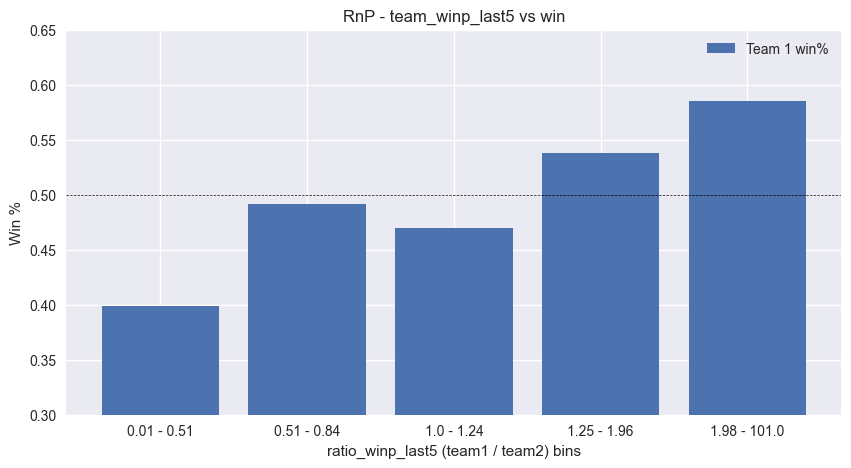

In [24]:
# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)

In [25]:
train_data.drop(columns=['winner_01'], inplace=True) # Dropping intermediate column made to plot RnP.

## 3. teamonly_avg_runs_last15

In [26]:
# team1's avg inning runs in last 15 games

## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)

In [27]:
match_lvl_data.head(2)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id,team1_bat_inning
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN,1
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0,1


In [28]:
def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.

In [29]:
# Compute average runs scored by team1 in their last 15 games for train data.
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)

100%|██████████| 948/948 [00:02<00:00, 461.02it/s]


In [30]:
# Similarly for test data.
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
test_data.shape
test_data.head(2)

100%|██████████| 271/271 [00:00<00:00, 470.98it/s]


(271, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5


In [31]:
train_data.shape
train_data.head(2)

(948, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000


## 4. teamone_winp_teamtwo_last15

In [32]:
# Team1's win percentage againts Team2 in last 15 games

def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.

In [33]:
# Compute team1 win% against team2 in their past 15 encounters for train data.
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

100%|██████████| 948/948 [00:00<00:00, 994.41it/s] 


In [34]:
train_data.shape
train_data.head(2)

(948, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000


In [35]:
# Similarly for test data.
test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

100%|██████████| 271/271 [00:00<00:00, 939.28it/s]


In [36]:
test_data.shape
test_data.head(2)

(271, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5


## 5. ground_avg_runs_last15

In [37]:
# average runs scored in the ground in last 15 games

def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.

In [38]:
## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)
## Similarly for test data.
test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)

100%|██████████| 271/271 [00:00<00:00, 1070.50it/s]


In [39]:
train_data.shape
train_data.head(2)

(948, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000


# Writing to CSV

In [25]:
train_data.to_csv('train_data_with_samplefeatures', index=False)
test_data.to_csv('test_data_with_samplefeatures', index=False)